In [1]:
!python --version

Python 3.10.12


# Dependencies

In [2]:
!pip install roboflow ultralytics supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 1.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [3]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from roboflow import Roboflow
from ultralytics import YOLO
from IPython.display import Image as IPyImage

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Importing dataset

In [5]:
HOME = os.getcwd()

In [6]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

/kaggle/working/datasets


In [7]:
rf = Roboflow(api_key="mO7qlobiaGbOPlDoDT4s")
project = rf.workspace("dimash").project("spacevela-3d-cv-1-class-fail")
version = project.version(16)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SpaceVela-3D/CV-1-class-fail-16 in yolov11:: 100%|██████████| 2606/2606 [00:00<00:00, 7794.53it/s]


# Importing YOLO11-Seg model and Training

In [8]:
%cd {HOME}

/kaggle/working


In [9]:
print(dataset.location)

/kaggle/working/datasets/SpaceVela-3D/CV-1-class-fail-16


In [10]:
data_yaml_path = os.path.join(dataset.location, "data.yaml")

In [11]:
!yolo task=segment mode=train model=yolo11s-seg.pt data={data_yaml_path} epochs=240 imgsz=640 plots=True

100%|██████████████████████████████████████| 19.7M/19.7M [00:00<00:00, 84.1MB/s]
Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/kaggle/working/datasets/SpaceVela-3D/CV-1-class-fail-16/data.yaml, epochs=240, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None

# Evaluating the Model

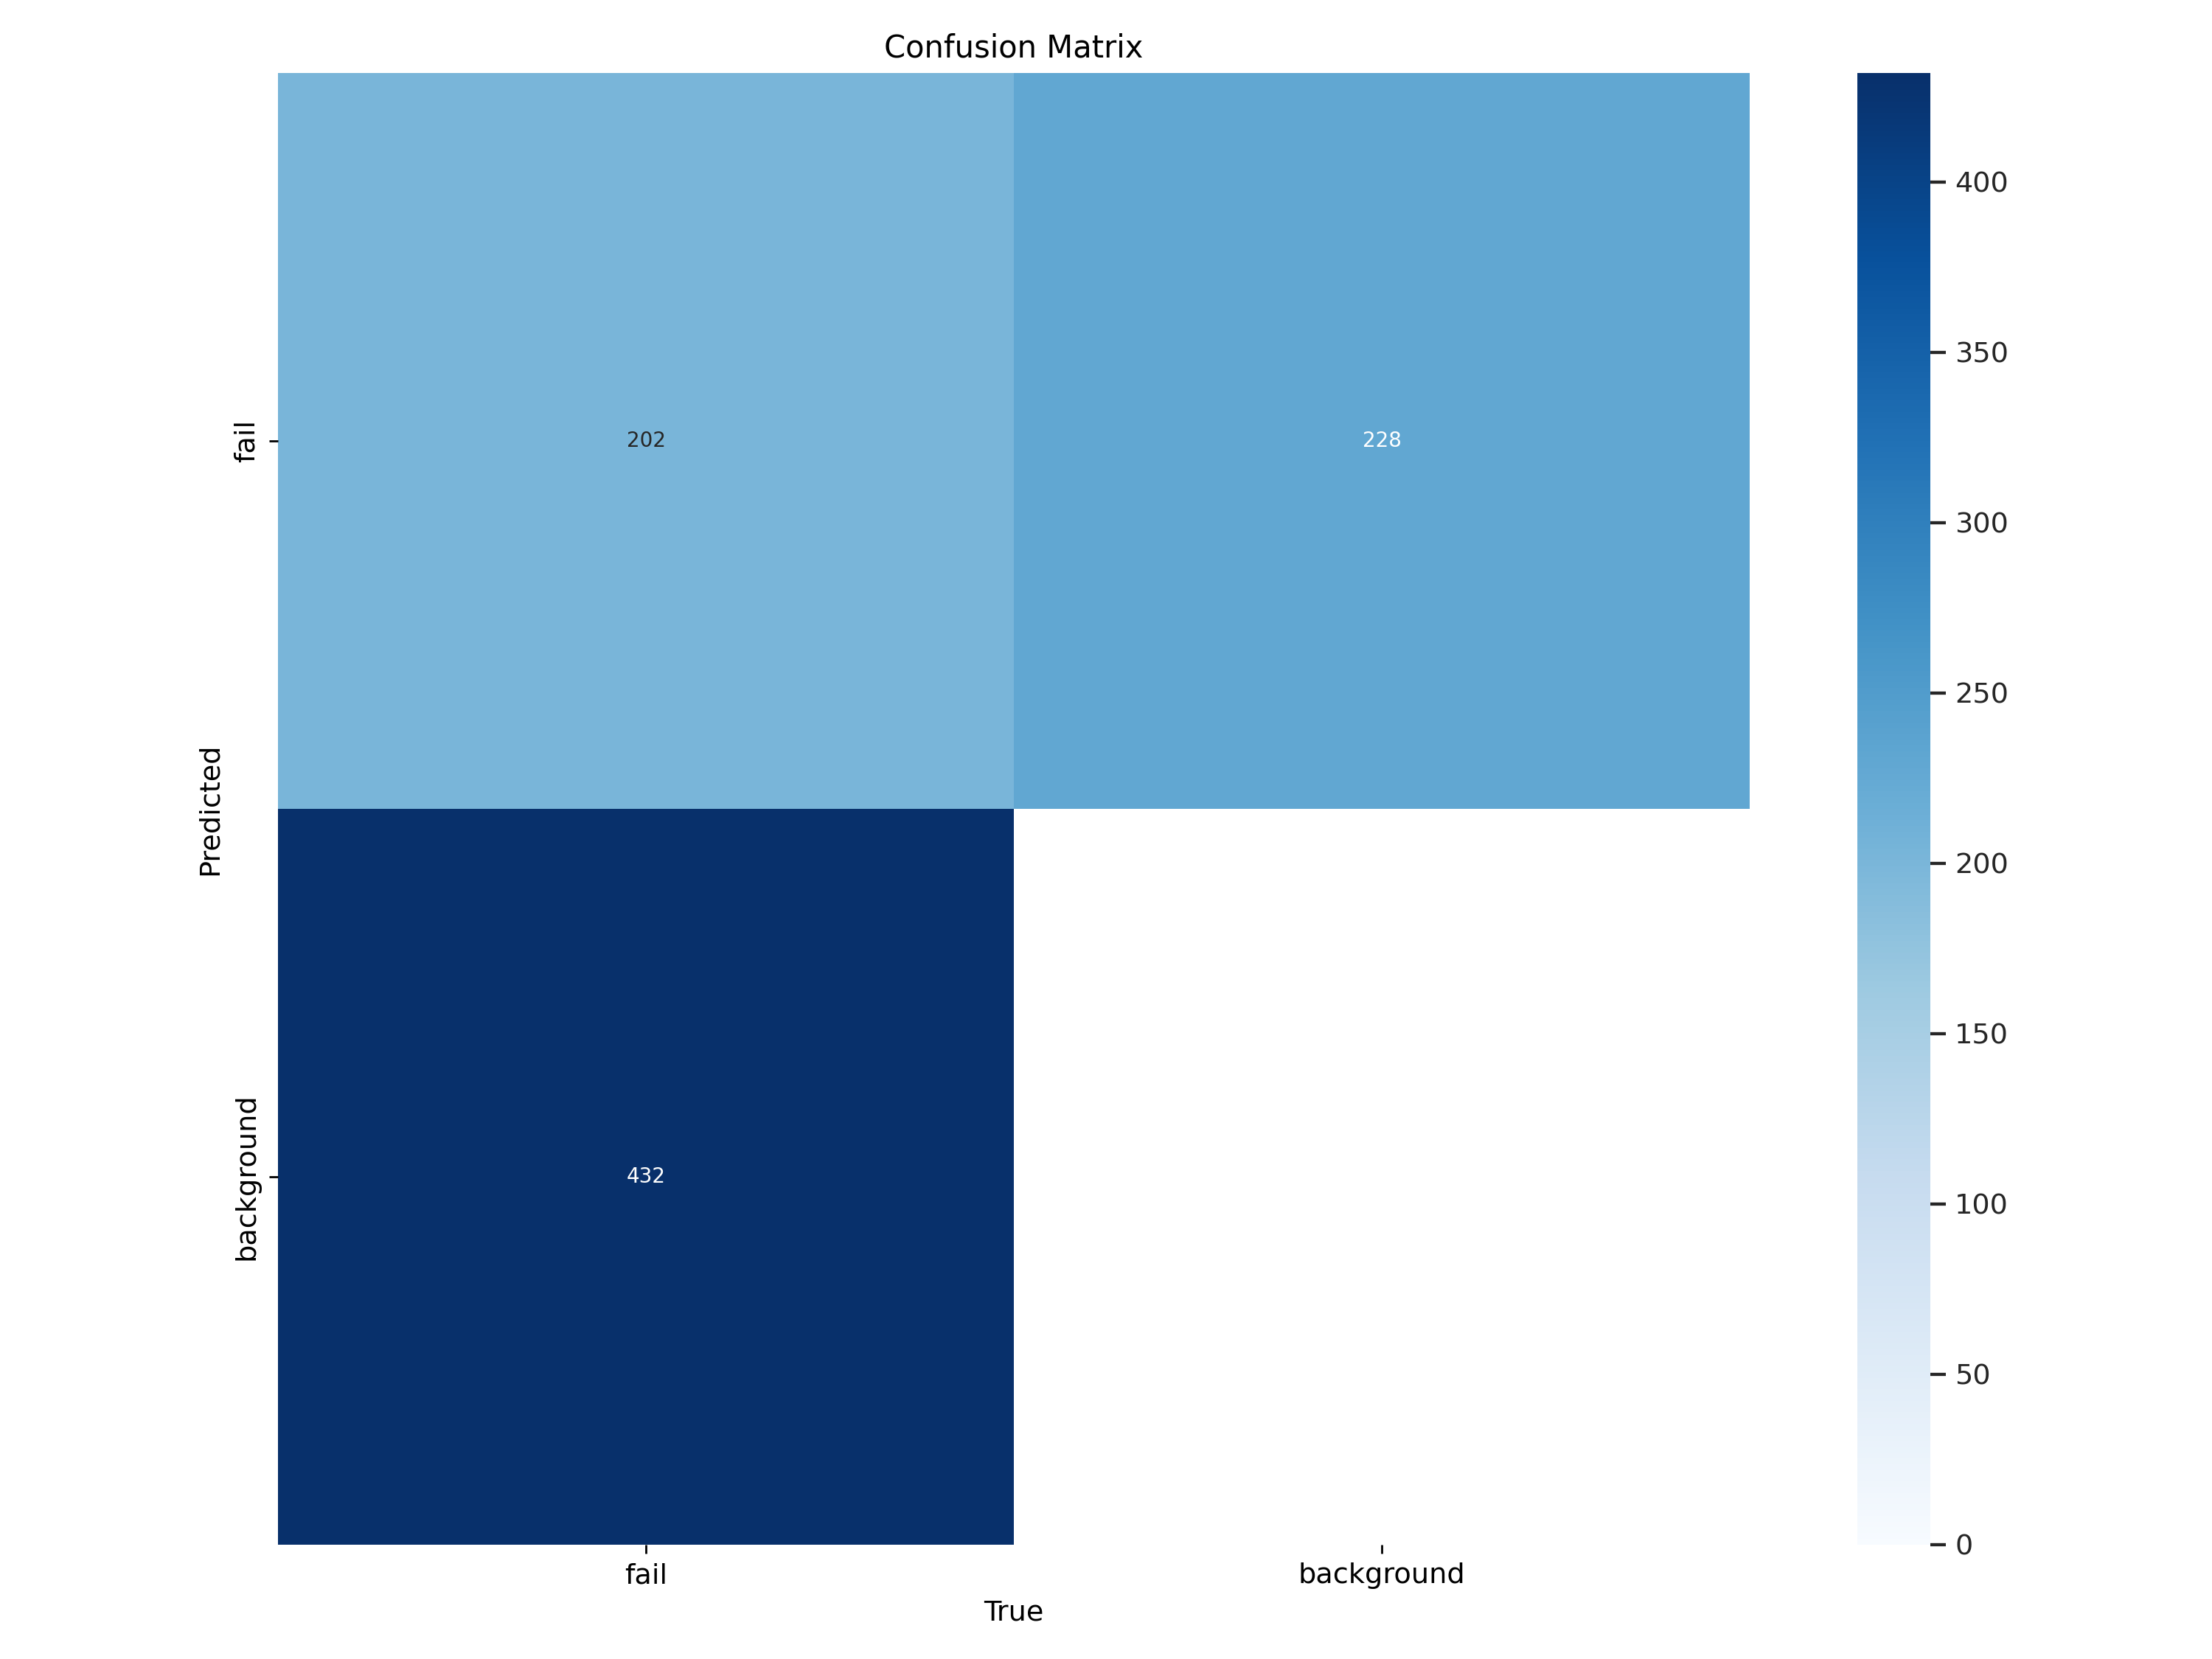

In [18]:
# Confusion Matrix
IPyImage(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

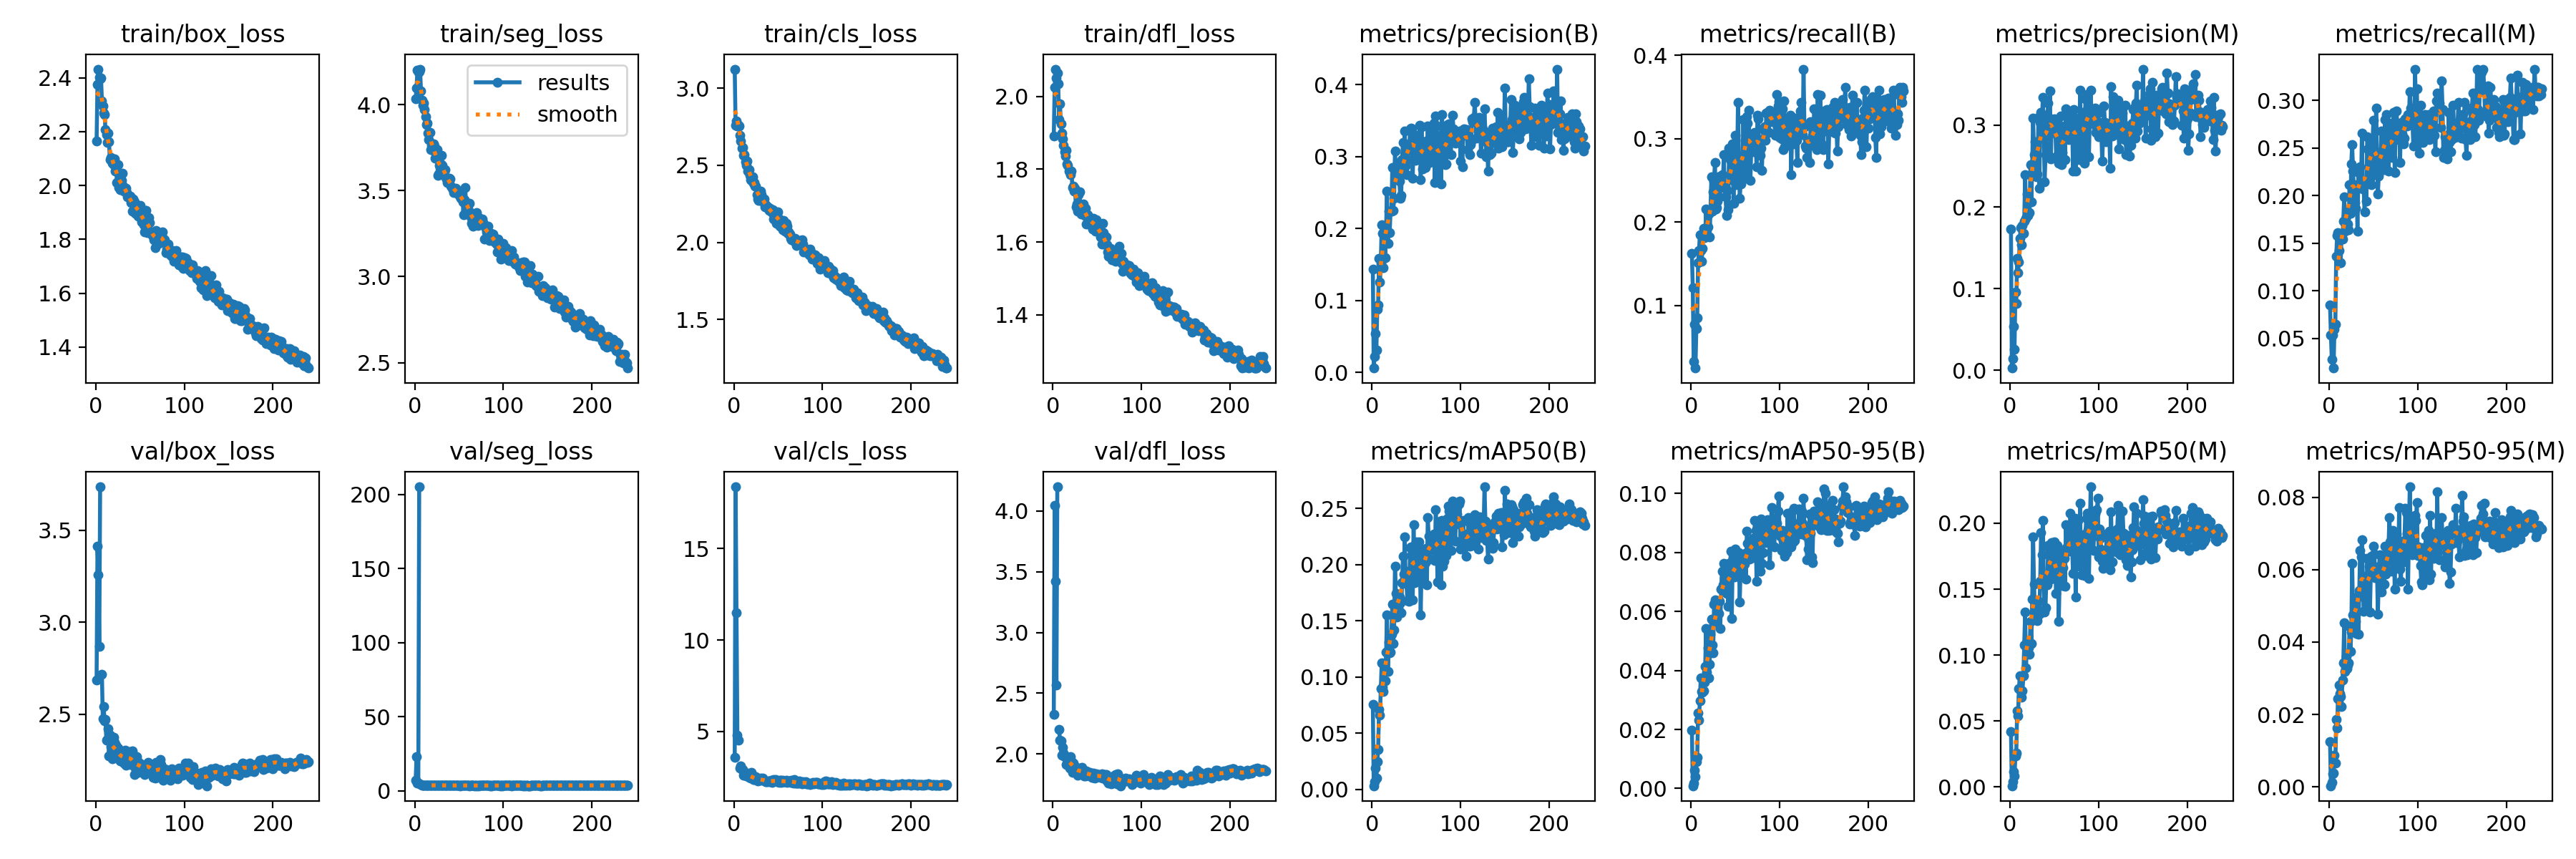

In [13]:
# Graphs for loss, precision, recall and mAP50
IPyImage(filename=f'{HOME}/runs/segment/train/results.png', width=600)

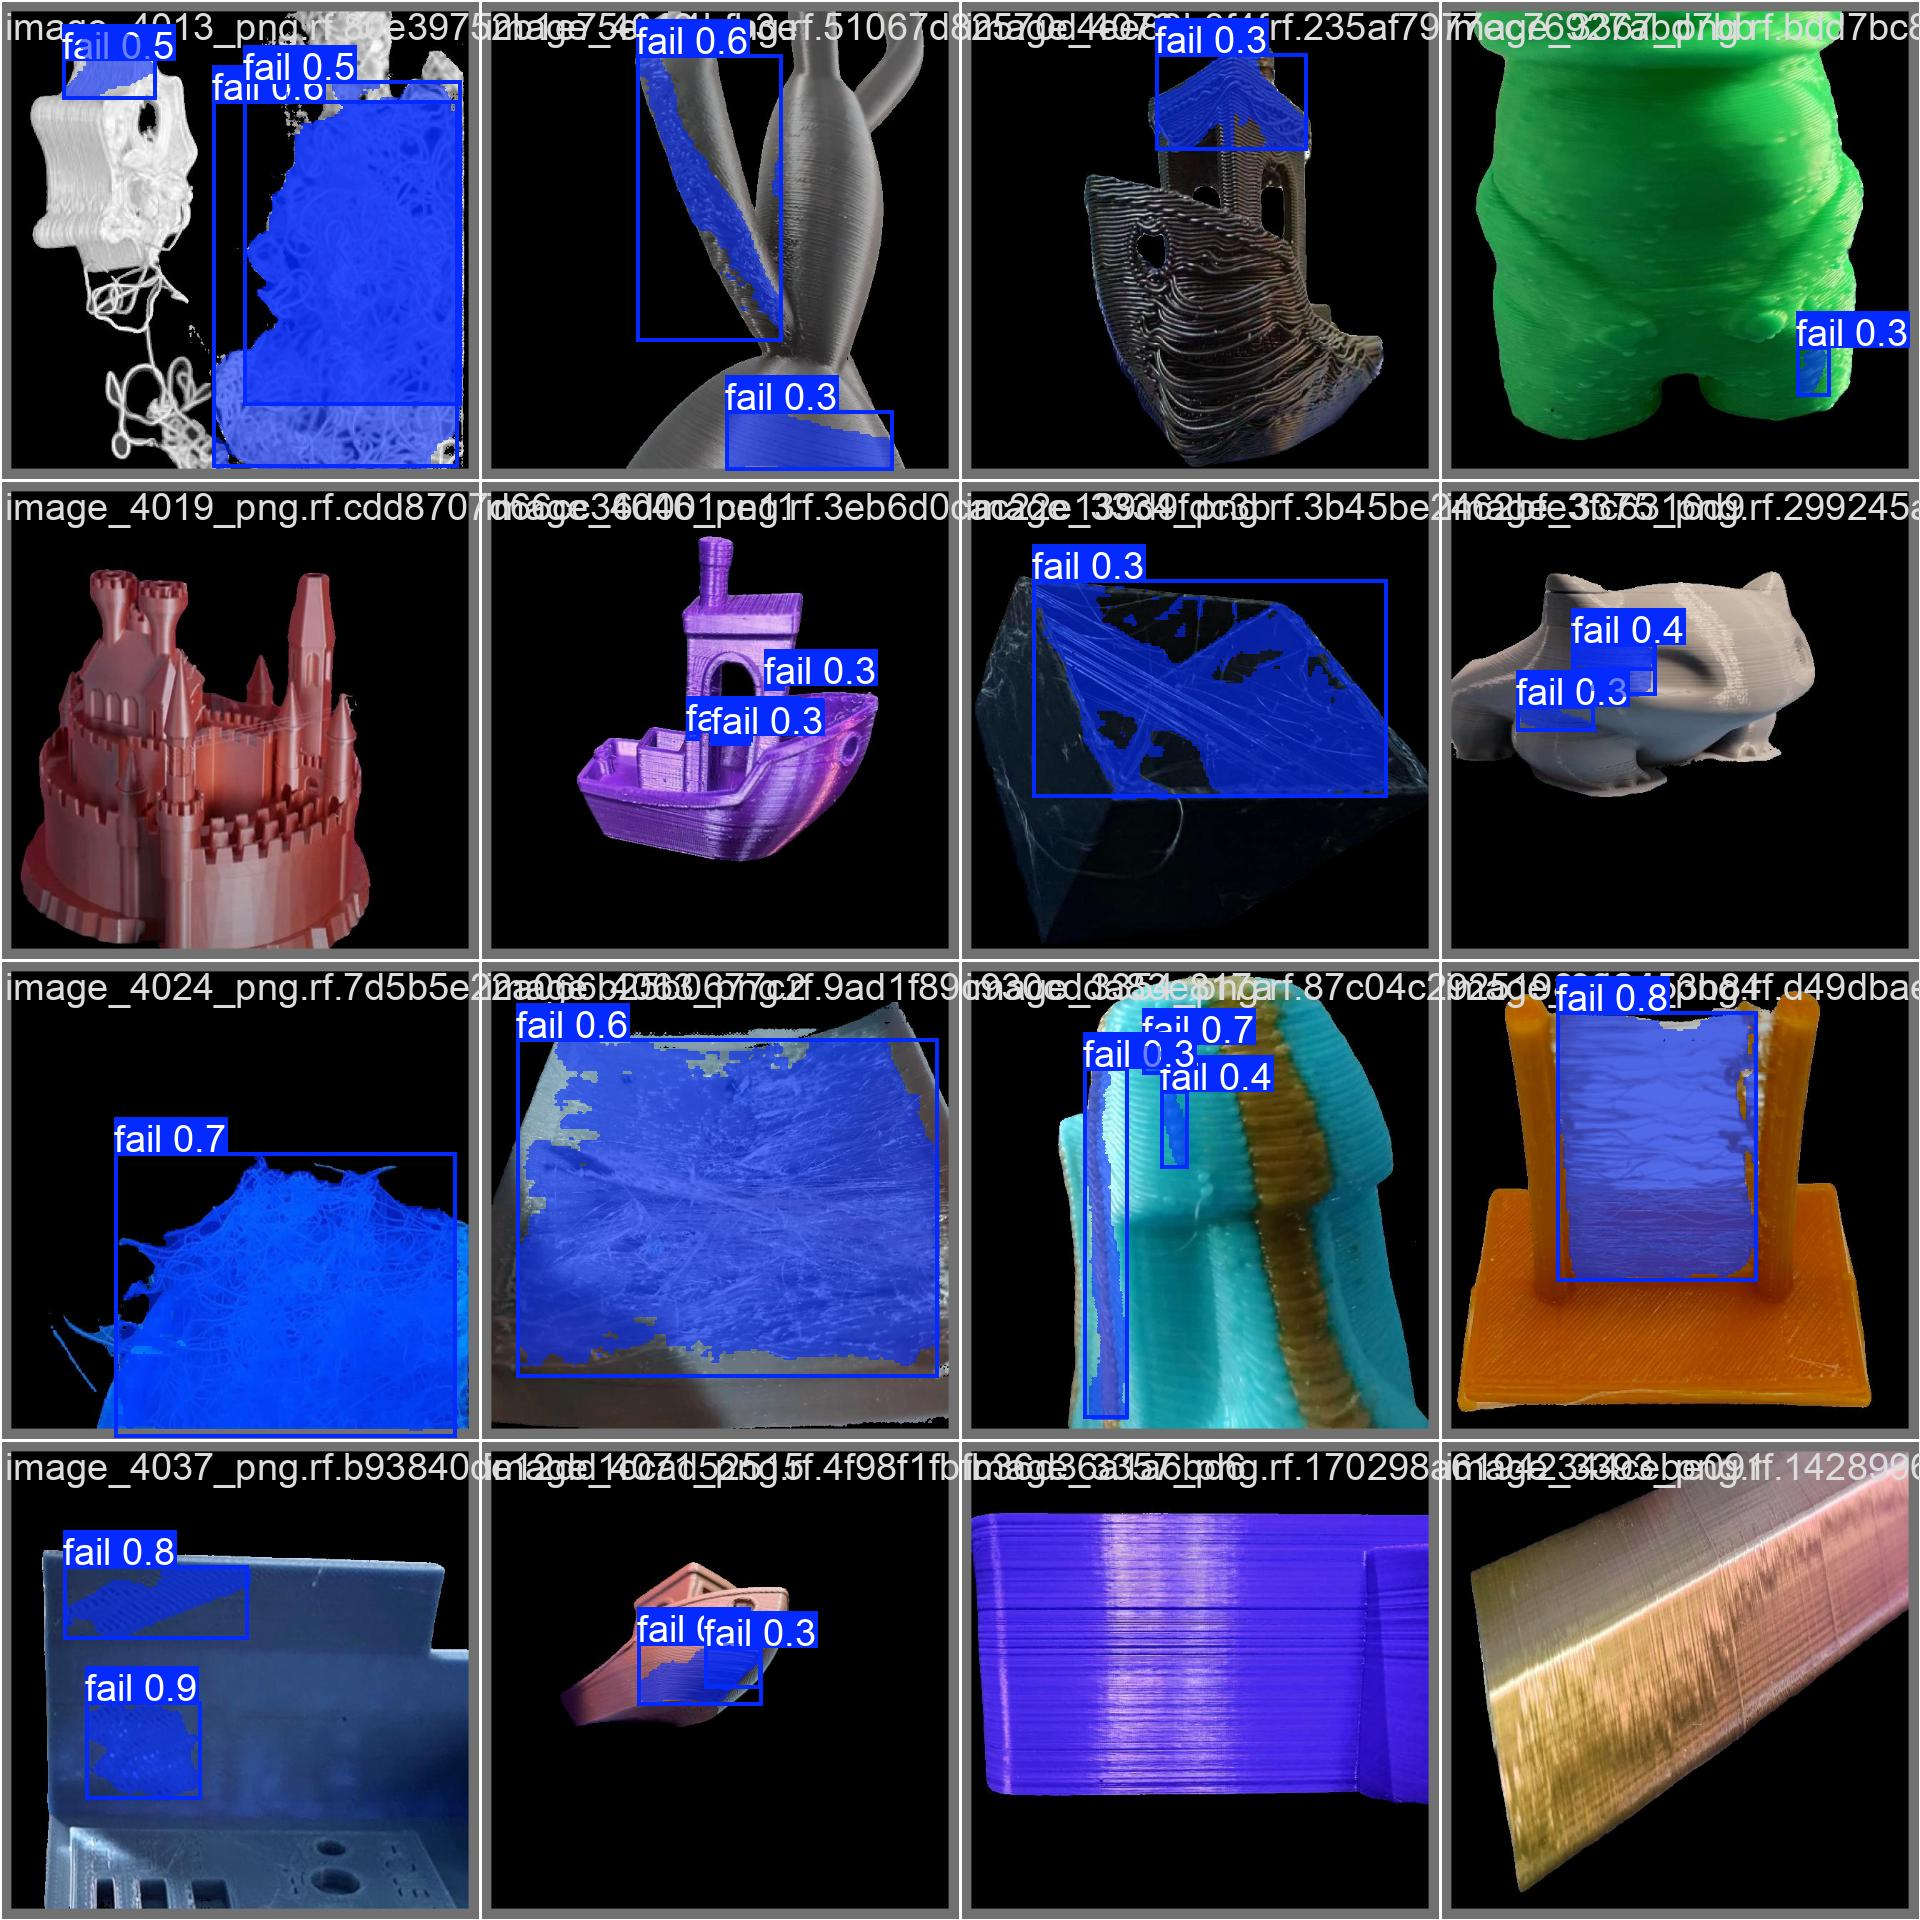

In [14]:
# Few instances of segmentation
IPyImage(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=800)

In [19]:
# Define metric functions
def compute_metrics(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou = intersection / union if union > 0 else 0
    dice = (2 * intersection) / (pred_mask.sum() + gt_mask.sum()) if (pred_mask.sum() + gt_mask.sum()) > 0 else 0
    tp = intersection
    fp = pred_mask.sum() - intersection
    fn = gt_mask.sum() - intersection
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return iou, dice, precision, recall, f1_score

In [24]:
from glob import glob

# Load the trained YOLO model
model = YOLO("/kaggle/working/runs/segment/train/weights/best.pt")

# Path to validation images
val_images = glob("/kaggle/working/datasets/SpaceVela-3D/CV-1-class-fail-16/valid/images/*.jpg")

# Path to ground truth labels
label_path = "/kaggle/working/datasets/SpaceVela-3D/CV-1-class-fail-16/valid/labels"

# Run inference on validation images
results = model(val_images)


0: 640x640 4 fails, 12.4ms
1: 640x640 2 fails, 12.4ms
2: 640x640 1 fail, 12.4ms
3: 640x640 2 fails, 12.4ms
4: 640x640 (no detections), 12.4ms
5: 640x640 2 fails, 12.4ms
6: 640x640 1 fail, 12.4ms
7: 640x640 (no detections), 12.4ms
8: 640x640 1 fail, 12.4ms
9: 640x640 2 fails, 12.4ms
10: 640x640 (no detections), 12.4ms
11: 640x640 3 fails, 12.4ms
12: 640x640 1 fail, 12.4ms
13: 640x640 3 fails, 12.4ms
14: 640x640 2 fails, 12.4ms
15: 640x640 4 fails, 12.4ms
16: 640x640 2 fails, 12.4ms
17: 640x640 1 fail, 12.4ms
18: 640x640 (no detections), 12.4ms
19: 640x640 1 fail, 12.4ms
20: 640x640 1 fail, 12.4ms
21: 640x640 1 fail, 12.4ms
22: 640x640 2 fails, 12.4ms
23: 640x640 3 fails, 12.4ms
24: 640x640 2 fails, 12.4ms
25: 640x640 3 fails, 12.4ms
26: 640x640 1 fail, 12.4ms
27: 640x640 21 fails, 12.4ms
28: 640x640 1 fail, 12.4ms
29: 640x640 26 fails, 12.4ms
30: 640x640 1 fail, 12.4ms
31: 640x640 1 fail, 12.4ms
32: 640x640 4 fails, 12.4ms
33: 640x640 3 fails, 12.4ms
34: 640x640 4 fails, 12.4ms
35: 640

In [25]:
# Function to convert YOLO segmentation labels to binary masks
def yolo_to_mask(label_file, image_shape):
    h, w = image_shape
    mask = np.zeros((h, w), dtype=np.uint8)
    
    with open(label_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        values = line.strip().split()
        if len(values) > 5:  # Ensure segmentation points exist
            points = np.array(values[5:], dtype=np.float32).reshape(-1, 2)
            points[:, 0] *= w  # Convert normalized x to pixel coordinates
            points[:, 1] *= h  # Convert normalized y to pixel coordinates
            points = points.astype(np.int32)
            cv2.fillPoly(mask, [points], 1)  # Draw filled polygon on mask

    return mask

In [27]:
# Define lists to store metrics
ious, dices, precisions, recalls, f1_scores = [], [], [], [], []

# Iterate through results and calculate metrics
for idx, result in enumerate(results):
    image_path = val_images[idx]
    image = cv2.imread(image_path)
    image_h, image_w = image.shape[:2]

    # Get predicted mask
    if result.masks is None or result.masks.data.numel() == 0:  # Check if tensor has elements
        pred_mask = np.zeros((image_h, image_w), dtype=np.uint8)
    else:
        pred_mask = result.masks.data[0].cpu().numpy()
        pred_mask = cv2.resize(pred_mask, (image_w, image_h))  # Resize to match image
        pred_mask = (pred_mask > 0.5).astype(np.uint8)


    # Load ground truth mask from YOLO labels
    label_file = os.path.join(label_path, os.path.basename(image_path).replace(".jpg", ".txt"))
    
    if not os.path.exists(label_file):
        print(f"Warning: Label file not found for {image_path}")
        continue

    gt_mask = yolo_to_mask(label_file, (image_h, image_w))

    # Compute metrics
    iou, dice, precision, recall, f1 = compute_metrics(pred_mask, gt_mask)

    # Store metrics
    ious.append(iou)
    dices.append(dice)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Image: {image_path} -> IoU: {iou:.4f}, Dice: {dice:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Compute and print overall metrics
print("\nOverall Metrics:")
print(f"IoU: {np.mean(ious):.4f}")
print(f"Dice Coefficient: {np.mean(dices):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1-score: {np.mean(f1_scores):.4f}")

Image: /kaggle/working/datasets/SpaceVela-3D/CV-1-class-fail-16/valid/images/image_3691_png.rf.8a1d24818a3832c2535a977d734ac8e5.jpg -> IoU: 0.1726, Dice: 0.2944, Precision: 0.3572, Recall: 0.2505, F1-score: 0.2944
Image: /kaggle/working/datasets/SpaceVela-3D/CV-1-class-fail-16/valid/images/image_3862_png.rf.35569c8690db12957605ef5036246591.jpg -> IoU: 0.0000, Dice: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Image: /kaggle/working/datasets/SpaceVela-3D/CV-1-class-fail-16/valid/images/image_3990_png.rf.f171c526aa4c0c4585ab37cac4055c07.jpg -> IoU: 0.1972, Dice: 0.3294, Precision: 0.2354, Recall: 0.5488, F1-score: 0.3294
Image: /kaggle/working/datasets/SpaceVela-3D/CV-1-class-fail-16/valid/images/image_3786_png.rf.b4138d11c5033039f2ee50412a26982d.jpg -> IoU: 0.2184, Dice: 0.3585, Precision: 0.3124, Recall: 0.4207, F1-score: 0.3585
Image: /kaggle/working/datasets/SpaceVela-3D/CV-1-class-fail-16/valid/images/image_3566_png.rf.e98dc75546e914774449fd5a6bf5b12b.jpg -> IoU: 0.00

# Exporting the Model

Download model straight from the notebook directory or publish the model in Roboflow (but the free limit has been used up, so there is no choice anyway)

In [ ]:
# model_path = os.path.join(HOME, "runs", "segment", "train")
# project.version(dataset.version).deploy(model_type="yolov11", model_path=model_path)

# References

1. https://docs.ultralytics.com/tasks/segment
2. https://blog.roboflow.com/train-yolov11-instance-segmentation